In [29]:
%load_ext autoreload
%autoreload 2
%run nnn/ipynb_init.py
%matplotlib inline
import itertools

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
arr = pd.read_csv('./data/models/raw/arr_v0.csv', index_col=0)
bae_ddG = pd.read_table('./data/literature/Bae_mismatch.tsv', sep='\t').set_index('mismatch')

## More mismatch hairpins please

In [3]:
def find_mismatch_parent(s:str, ref:pd.Series):
    
    # found = False
    parent, tag = 'na', 'na'
    
    if s in ref.values:
        parent = ref[ref == s].index[0]
        tag = '-'
    
    
    for i,r in enumerate(ref):

        if len(s) == len(r):
            n_same, n_diff = 0, 0
            for j in range(len(r)):
                if s[j] == r[j]:
                    n_same += 1

            if n_same + 1 == len(r):
                found = True
                parent = ref.index[i]
                for j in range(len(r)):
                    if s[j] != r[j]:
                        tag = f'{r[j]}>{s[j]}'
                        break
                        
    return parent, tag

# To adjust Na from 1x melt buffer to 1xPBS
def adjust_salt_dG_37(row):
    return util.get_Na_adjusted_dG_37(row.Tm, row.dH, row.GC, Na=0.161, from_Na=0.088)

The authors of the Bae control paper only gave us `G>N` mismatch data. I further look for other mismatches to include in the validation dataset, first in the BaeControls part of the array data:

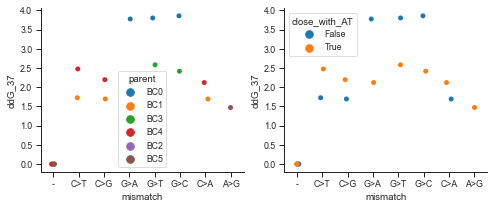

In [11]:
# Plot all the Bae control mismatches
df = arr.query('ConstructType == "BaeControls"')
ref = df.loc[['BC%d'%i for i in range(6)],'RefSeq']
result = df.RefSeq.apply(lambda s: find_mismatch_parent(s, ref))
df[['parent', 'mismatch']] = np.array([list(x) for x in result.values])
df['ddG_37'] = df['dG_37'] - df.parent.apply(lambda p: df.loc[p, 'dG_37'])
df['close_with_AT'] = df.RefSeq.apply(lambda s: s[0] in ['A', 'T'])

fig, ax = plt.subplots(1, 2, figsize=(8,3))
sns.stripplot(data=df, y='ddG_37', x='mismatch', hue='parent', ax=ax[0])
sns.stripplot(data=df, y='ddG_37', x='mismatch', hue='close_with_AT', ax=ax[1])
sns.despine()

We only select the ones that close with GC

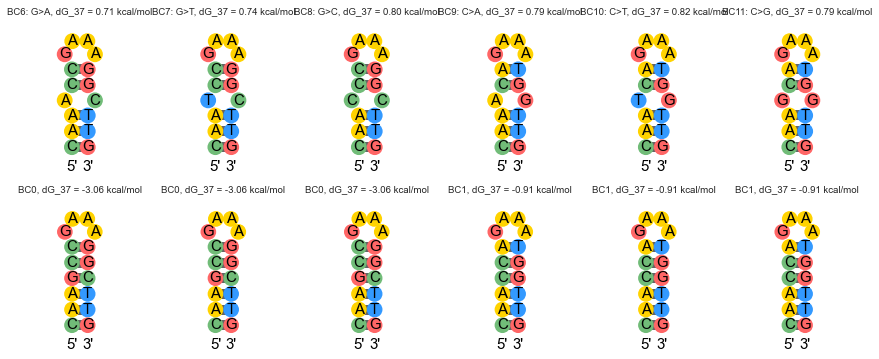

In [12]:
fig, ax = plt.subplots(2, 6, figsize=(15,6))
j = 0
for i in (6,7,8,9,10,11):
    seqid = 'BC%d'%i
    if seqid in df.index:
        draw_struct(df.loc[seqid, 'RefSeq'], df.loc[seqid, 'TargetStruct'], ax=ax[0][j])
        parent = df.loc[seqid, 'parent']
        draw_struct(df.loc[parent, 'RefSeq'], df.loc[parent, 'TargetStruct'], ax=ax[1][j])
        ax[0][j].set_title('%s: %s, dG_37 = %.2f kcal/mol' % (seqid, df.loc[seqid, "mismatch"], df.loc[seqid, "dG_37"]))
        ax[1][j].set_title('%s, dG_37 = %.2f kcal/mol' % (parent, df.loc[parent, "dG_37"]))
        j += 1
    
util.save_fig('./fig/Bae/structures_uvmelt_plotted.pdf')

Now we get `C>N` too. It's still not covering `A>N` and `T>N` mismatches. I further look into the whole array dataset for variants that satisfy the following criteria:

- 6 single mismatches of `A>N` and `T>N`
- has parent in the dataset
- closed with GC pair
- ~~same length as `BC0` and `BC1`~~ (all of them are 18 bp long)
- ideally with the same parent

In [19]:
df = arr.query('Series == "MisMatches"')
# only single mismatches
df = df[df.TargetStruct.apply(lambda x: x.count('.') == 6)]
# only those closing with GC pair
df = df[df.RefSeq.apply(lambda x: x[0] in ['C', 'G'])]

ref = arr.query('Series == "WatsonCrick"')
# only constructs with the same length as the mismatches are reference candidates
ref = ref[ref.RefSeq.apply(lambda x: len(x) == 18)]['RefSeq']
# only those closing with GC pair
ref = ref[ref.RefSeq.apply(lambda x: x[0] in ['C', 'G'])]

result = df.RefSeq.apply(lambda s: find_mismatch_parent(s, ref))
df[['parent', 'mismatch']] = np.array([list(x) for x in result.values])
df = df.query('parent != "na"')

df['ddG_37'] = df['dG_37'] - df.parent.apply(lambda p: arr.loc[p, 'dG_37'])

KeyError: 'na'

<AxesSubplot:xlabel='mismatch', ylabel='ddG_37'>

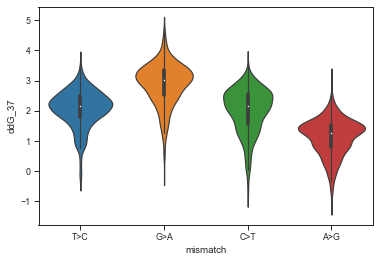

In [28]:
sns.violinplot(data=df, y='ddG_37', x='mismatch')

Unfortunately, we still don't get enough A/T ones from those whose parents are in WC series. Still, we have one lucky reference surviver from the MisMatches series, from whom 18 healthy descendents are derived:

<AxesSubplot:xlabel='mismatch', ylabel='ddG_37'>

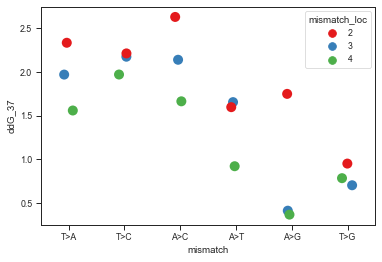

In [30]:
df = arr.query('Series == "MisMatches"')
# only single mismatches
df = df[df.TargetStruct.apply(lambda x: x.count('.') == 6)]
# only those closing with GC pair
df = df[df.RefSeq.apply(lambda x: x[0] in ['C', 'G'])]

ref = arr[arr.Series == "MisMatches"]
ref = ref[ref.TargetStruct.apply(lambda x: x.count('.') == 4)]['RefSeq']

result = df.RefSeq.apply(lambda s: find_mismatch_parent(s, ref))
df[['parent', 'mismatch']] = np.array([list(x) for x in result.values])
df = df.query('parent != "na"')

df['ddG_37'] = df['dG_37'] - df.parent.apply(lambda p: arr.loc[p, 'dG_37'])
df['mismatch_loc'] = df.TargetStruct.apply(lambda x: x.find('.'))

sns.stripplot(data=df, y='ddG_37', x='mismatch', hue='mismatch_loc', palette='Set1', size=10)

Look at out lil :star:

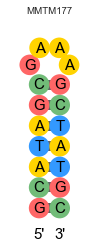

In [33]:
plotting.draw_target_struct('MMTM177', arr)

And its many babies

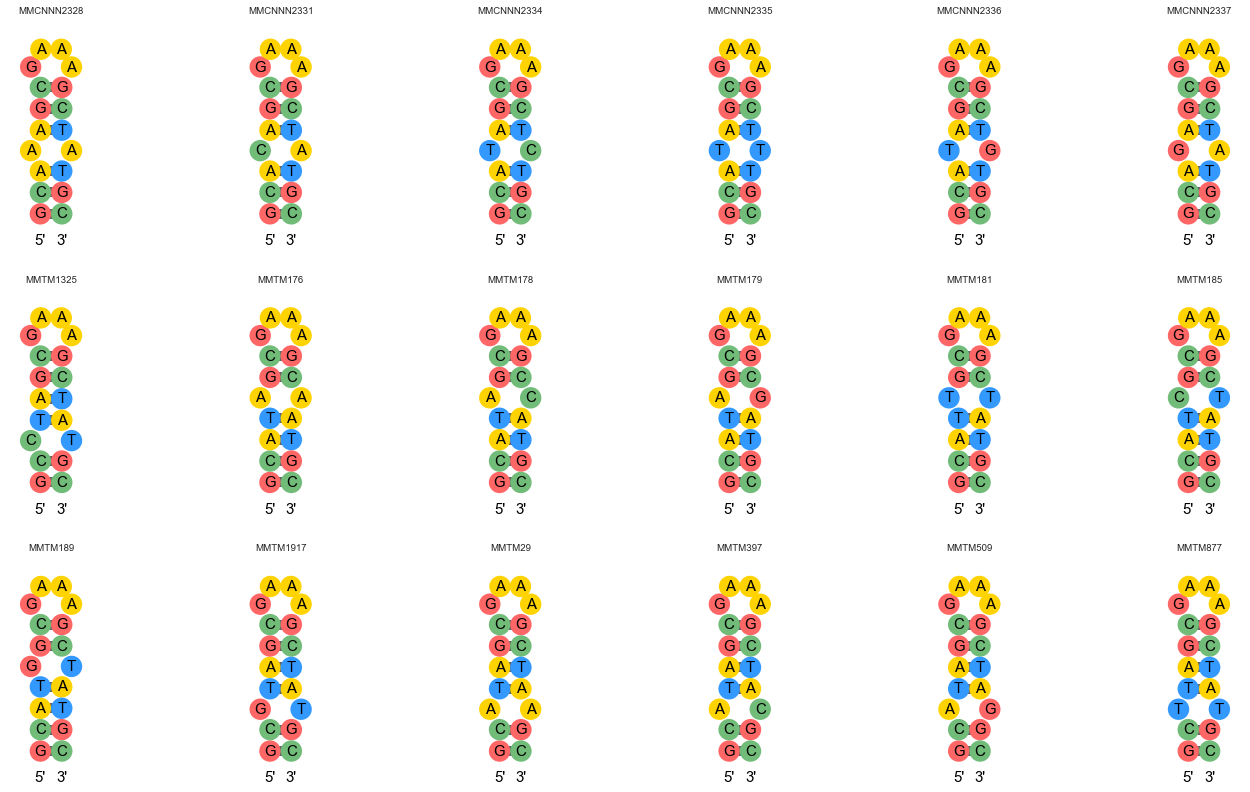

In [32]:
fig, ax = plt.subplots(3, 6, figsize=(24,14))
ax = ax.flatten()
for i,seqid in enumerate(df.index):
    plotting.draw_target_struct(seqid, arr, ax=ax[i])

Hahahahahahaha very nice.

So ring ring ring here's our finalists:

In [34]:
finalists = ['BC%d' % i for i in (0,1,6,7,8,9,10,11)] + ['MMTM177'] + df.index.tolist()

Export shit for IDT the sucker

In [39]:
arr.loc[finalists, 'RefSeq'].to_csv('./data/uv_melt/design/MM_27_IDT.csv')

## get the moms for duplex_14

I was silly and forgot the moms last time. Just get the reverse compliment of the 3p strands and order them for reference.

In [44]:
duplex_14 = pd.read_csv('./data/uv_melt/design/duplex_mm_bg_14.csv', index_col=0)

duplex_14['rc'] = duplex_14.sequence.apply(util.rcompliment)

duplex_14['order_rc'] = duplex_14.apply(lambda row: row.name.endswith('_3p'), axis=1)

duplex_14_rc = duplex_14.query('order_rc').rc
duplex_14_rc.index = duplex_14_rc.index.to_series().apply(lambda x: x+'_rc')

duplex_14_rc.to_csv('./data/uv_melt/design/duplex_mm_bg_14_rc_idt.csv')

## Extra tetraloops / triloops

Previously we only measured 5 tetraloop constructs. To make a better argument, I need more datapoints with a certain amount of diversity & with references for ddG calculation.

- have living parents
- ideally with the same backbone
- cover all outer inner pairs
- validate something interesting we found in the dataset

Similarly, we add some more triloops.

So, our first question is, what are some **interesting findings** in the dataset that we want to validate?

### Exploration to find something interesting

In [64]:
annotation_file = './data/annotation/NNNlib2b_annotation_20220519.tsv'
annotation = fileio.read_annotation(annotation_file, sodium=0.081)

Text(0.5, 1.0, 'measured $dG°_{37}$ (kcal/mol)')

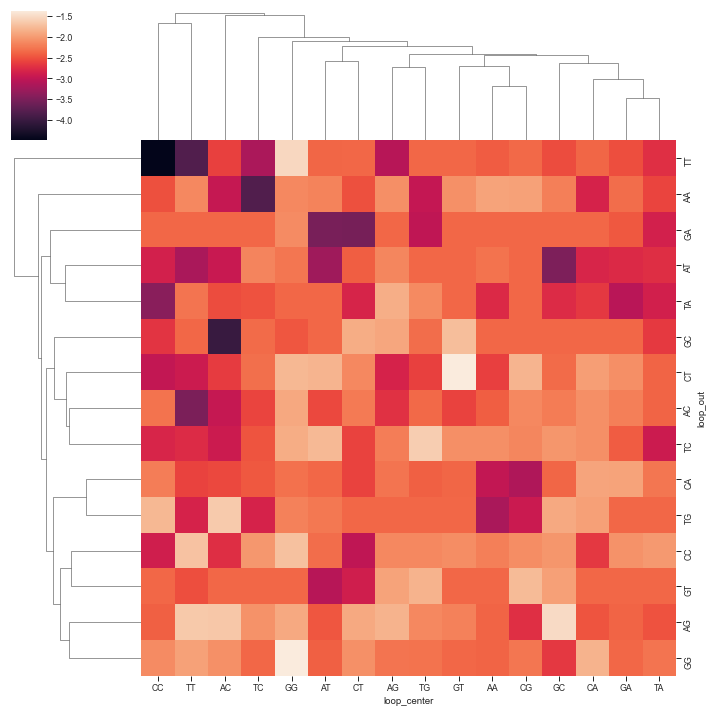

In [290]:
query = 'Series == "TETRAloop" & ConstructType == "NN" & bottomScaffold == "CGCGCGCG"'
df = arr.query(query)

def get_loop(seq, loop_size=4):
    stem_size = int((len(seq) - loop_size) / 2)
    return seq[stem_size: stem_size+loop_size]

def get_closing_stack(seq, loop_size=4, closing_stack_size=1):
    stem_size = int((len(seq) - loop_size) / 2)
    return seq[stem_size - closing_stack_size : stem_size] + seq[-stem_size : -stem_size + closing_stack_size]


df['loop'] = df.RefSeq.apply(lambda seq: get_loop(seq, loop_size=4))
df['closing_stack'] = df.RefSeq.apply(lambda seq: get_closing_stack(seq, loop_size=4, closing_stack_size=1))
df.sort_values(by='loop', inplace=True)
df = df.query('closing_stack == "GC" | closing_stack == "GC"')
df['loop_out'] = df.apply(lambda x: x.loop[0]+x.loop[-1], axis=1)
df['loop_center'] = df['loop'].apply(lambda x: x[1:3])

pivot_array = df.pivot_table(index='loop_out', columns='loop_center', values='dG_37')
pivot_array.fillna(np.nanmedian(pivot_array.values), inplace=True)
pivot_array_nupack = df.pivot_table(index='loop_out', columns='loop_center', values='dG_37_NUPACK_salt_corrected')
pivot_array_nupack.fillna(np.nanmedian(pivot_array_nupack.values), inplace=True)

sns.clustermap(pivot_array)
ax[0].set_title('measured $dG°_{37}$ (kcal/mol)')

# util.save_fig('./fig/heatmaps/tetraloop_scaffoldA_dG_37.pdf')

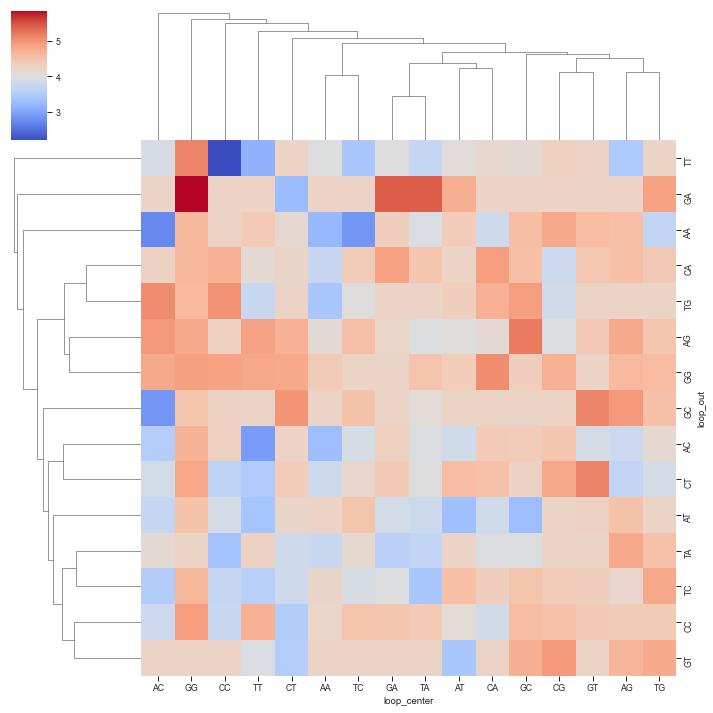

In [162]:
sns.clustermap(pivot_array - pivot_array_nupack, cmap='coolwarm', **args)

Text(0.5, 1.0, 'array - NUPACK $ddG°_{37}$ (kcal/mol)')

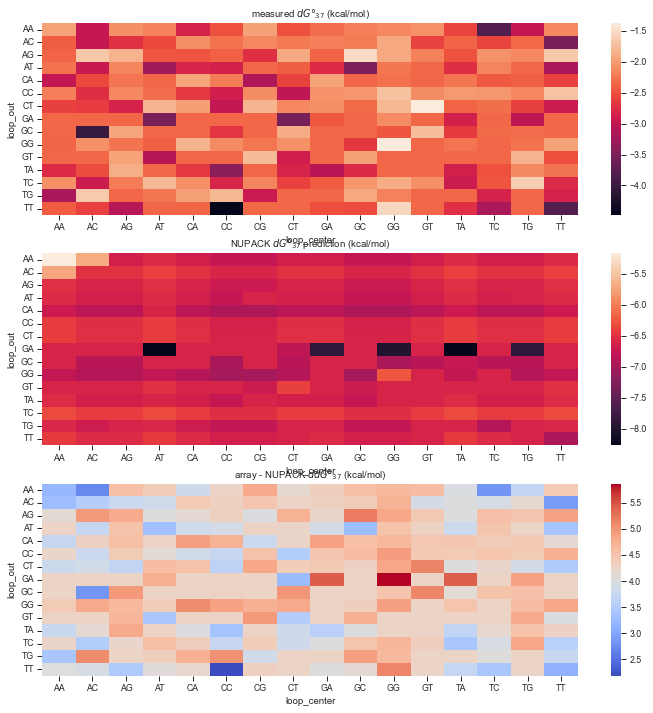

In [161]:
fig, ax = plt.subplots(3, 1, figsize=(12,12), sharex=False)
args = dict()#dict(vmin=-2.5, vmax=0)

sns.heatmap(pivot_array, ax=ax[0], **args)
ax[0].set_title('measured $dG°_{37}$ (kcal/mol)')
sns.heatmap(pivot_array_nupack, ax=ax[1], **args)
ax[1].set_title('NUPACK $dG°_{37}$ prediction (kcal/mol)')
sns.heatmap(pivot_array - pivot_array_nupack, ax=ax[2], cmap='coolwarm', **args)
ax[2].set_title('array - NUPACK $ddG°_{37}$ (kcal/mol)')

I don't see a lot of interesting patterns apart from a few outliers.

The outliers cannot be simply explained by unexpected alternative folding:

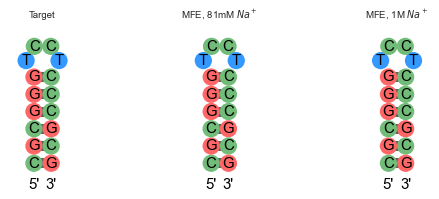

In [159]:
for seqid in df.query('loop_out == "TT" & loop_center == "CC"').index:
    # plotting.draw_target_struct(seqid, arr)
    plotting.draw_target_mfe_struct(arr.loc[seqid,:], celsius=76)

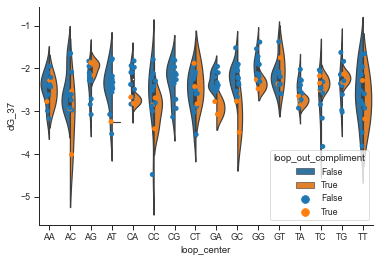

In [181]:
complement = {'A': 'T', 'C': 'G', 'G': 'C', 'T': 'A'}
df['loop_out_compliment'] = df.loop_out.apply(lambda x: x[1] == complement[x[0]])

sns.violinplot(data=df, x='loop_center', y='dG_37', hue='loop_out_compliment', split=True)
sns.stripplot(data=df, x='loop_center', y='dG_37', hue='loop_out_compliment')
sns.despine()

### Least explained tetra/triloops

These are the least certain parameters in linear model fitting. Used for enhancing training data for the models.

,dG_37_se
GAAA,0.055644
CGCG,0.048700
GCGC,0.047336
CTTG,0.041948
GGCC,0.040975
CGTG,0.036057
CCGG,0.033625
CTCG,0.032868
TTTA,0.029853
GCCA,0.029826


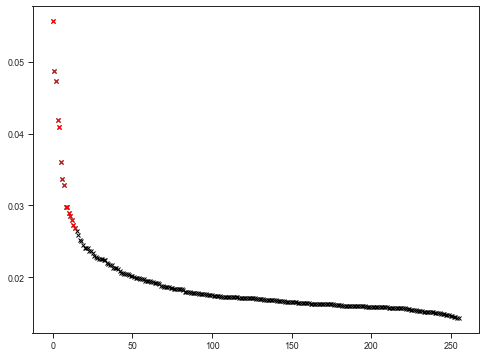

In [372]:
# A set of least explained tetraloops
df = arr.query('Series == "TETRAloop"')
df['scaffold'] = df.apply(lambda row: f'{row.bottomScaffold}_{row.topScaffold}', axis=1)
count_scaffold_list = np.unique(df.scaffold).tolist()#[[0]]

feats = mf.get_feature_count_matrix(df, feature_method='get_hairpin_loop_feature_list', 
                                    loop_base_size=0, fit_intercept=False, count_scaffold_list=count_scaffold_list)
y = df['dG_37']
y_err = df['dG_37_se']

hairpin_model = util.LinearRegressionSVD()
hairpin_model.fit(feats.values, y.values, y_err.values, feature_names=feats.columns.tolist())

model_se = hairpin_model.coef_se_df.sort_values('dG_37_se', ascending=False)
plt.figure(figsize=(8,6))
plt.plot(model_se.values, 'kx')
plt.plot(model_se.values[:15], 'rx')

model_se[:15]

In [353]:
tetraloop_explained_refseq = ['GATCAC%sGTGATC' % loop for loop in model_se[:15].index.tolist() + ['GACC', 'TTCC', 'GGGA']]

tetraloop_explain_df = pd.DataFrame(
    index=[annotation[annotation.RefSeq == refseq].index[0] for refseq in tetraloop_explained_refseq],
    data=tetraloop_explained_refseq)

,dG_37_se
GCA,0.031540
GTA,0.030068
GAA,0.026909
GGA,0.025190
GTC,0.020119
TTC,0.019976
GGC,0.019313
TTT,0.019089
GTT,0.019014
TCT,0.018941


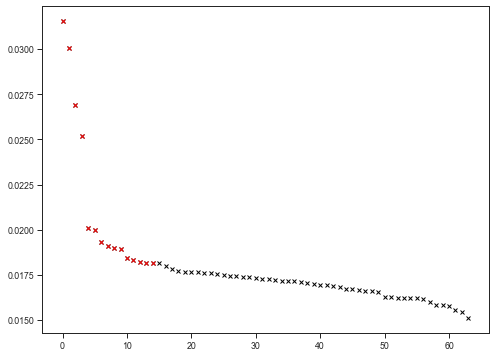

In [355]:
# A set of least explained triloops
df = arr.query('Series == "TRIloop"')
df['scaffold'] = df.apply(lambda row: f'{row.bottomScaffold}_{row.topScaffold}', axis=1)
count_scaffold_list = np.unique(df.scaffold).tolist()#[[0]]

feats = mf.get_feature_count_matrix(df, feature_method='get_hairpin_loop_feature_list', 
                                    loop_base_size=0, fit_intercept=False, count_scaffold_list=count_scaffold_list)
y = df['dG_37']
y_err = df['dG_37_se']

hairpin_model = util.LinearRegressionSVD()
hairpin_model.fit(feats.values, y.values, y_err.values, feature_names=feats.columns.tolist())

model_se = hairpin_model.coef_se_df.sort_values('dG_37_se', ascending=False)
plt.figure(figsize=(8,6))
plt.plot(model_se.values, 'kx')
plt.plot(model_se.values[:15], 'rx')

model_se[:12]

In [362]:
triloop_explained_refseq = ['GATCAC%sGTGATC' % loop for loop in model_se[:12].index.tolist()]

triloop_explain_df = pd.DataFrame(
    index=[annotation[annotation.RefSeq == refseq].index[0] for refseq in triloop_explained_refseq],
    data=triloop_explained_refseq)

In [376]:
# Finally, double check that nothing already uv melted are duplicated
sample_sheet_file = './data/uv_melt/ECLSampleSheet230106.csv'
measured = pd.read_csv(sample_sheet_file, index_col=0).SEQID

assert not triloop_explain_df.iloc[:,0].apply(lambda x: x in measured).any()
assert not tetraloop_explain_df.iloc[:,0].apply(lambda x: x in measured).any()
assert not pd.Series(finalists).apply(lambda x: x in measured).any()

### A few example loops to show example trends

- Change closing pair
- Change outer pair
- Change inner pair

Text(0.5, 1.0, 'measured $dG°_{37}$ (kcal/mol)')

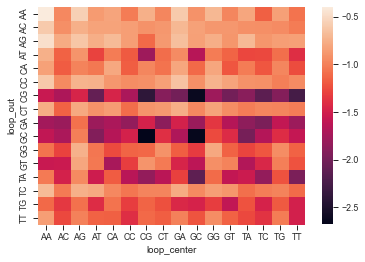

In [392]:
query = 'Series == "TETRAloop"'
df = arr.query(query)

df['loop'] = df.RefSeq.apply(lambda seq: get_loop(seq, loop_size=4))
df['closing_stack'] = df.RefSeq.apply(lambda seq: get_closing_stack(seq, loop_size=4, closing_stack_size=1))
df.sort_values(by='loop', inplace=True)
# df = df.query('closing_stack == "GC" | closing_stack == "GC"')
df['loop_out'] = df.apply(lambda x: x.loop[0]+x.loop[-1], axis=1)
df['loop_center'] = df['loop'].apply(lambda x: x[1:3])

pivot_array = df.pivot_table(index='loop_out', columns='loop_center', values='dG_37')
pivot_array.fillna(np.nanmedian(pivot_array.values), inplace=True)
pivot_array_nupack = df.pivot_table(index='loop_out', columns='loop_center', values='dG_37_NUPACK_salt_corrected')
pivot_array_nupack.fillna(np.nanmedian(pivot_array_nupack.values), inplace=True)

sns.heatmap(pivot_array)
ax[0].set_title('measured $dG°_{37}$ (kcal/mol)')

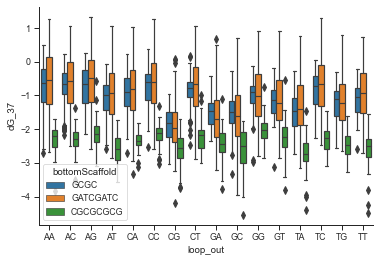

In [398]:
sns.boxplot(data=df, x='loop_out', y='dG_37', hue='bottomScaffold')
sns.despine()

Change outer pair:

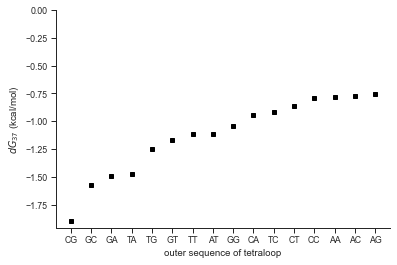

In [411]:
plt.plot(df.query('bottomScaffold == "GCGC"').groupby('loop_out').apply(np.mean).sort_values(by='dG_37')['dG_37'], 'ks')
plt.xlabel('outer sequence of tetraloop')
plt.ylabel('$dG_{37}$ (kcal/mol)')
plt.ylim(top=0)
sns.despine()

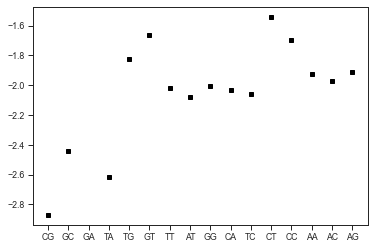

In [525]:
# in the same order as above
loop_out_refseq = ['GCGC%sAT%sGCGC' % (loop_out[0], loop_out[1]) for loop_out in 
    df.query('bottomScaffold == "GCGC"').groupby('loop_out').apply(np.mean).sort_values(by='dG_37').index]

loop_out_df = pd.DataFrame(
    index=[annotation[annotation.RefSeq == refseq].index[0] for refseq in loop_out_refseq],
    data=loop_out_refseq, columns=['RefSeq'])
loop_out_df['dG_37_array'] = pd.Series(loop_out_df.index).apply(lambda x: arr.loc[x, 'dG_37'] if x in arr.index.tolist() else np.nan).values
loop_out_df['loop_out'] = df.query('bottomScaffold == "GCGC"').groupby('loop_out').apply(np.mean).sort_values(by='dG_37').index.tolist()
plt.plot(df.query('bottomScaffold == "GCGC"').groupby('loop_out').apply(np.mean).sort_values(by='dG_37').index,
         pd.Series(loop_out_df.index).apply(lambda x: arr.loc[x, 'dG_37'] if x in arr.index.tolist() else np.nan), 
         'ks')

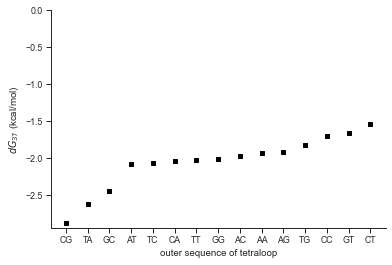

In [453]:
# sorted by dG_37
loop_out_df = loop_out_df.sort_values('dG_37_array')
plt.plot(loop_out_df.loop_out, loop_out_df.dG_37_array, 'ks')
plt.xlabel('outer sequence of tetraloop')
plt.ylabel('$dG_{37}$ (kcal/mol)')
plt.ylim(top=0)
sns.despine()

Get a series of loop center pairs too:

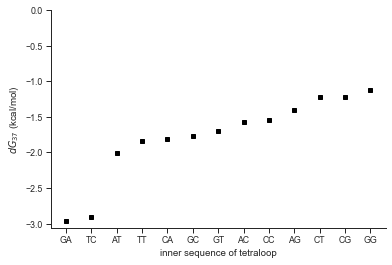

In [524]:
# in the same order as above
loop_center_refseq = ['GCGCG%sGGCGC' % (loop_center) for loop_center in 
    [''.join(x) for x in itertools.product('ATCG', 'ATCG')]]

loop_center_df = pd.DataFrame(
    index=[annotation[annotation.RefSeq == refseq].index[0] for refseq in loop_center_refseq],
    data=loop_center_refseq,
    columns=['RefSeq'])
loop_center_df['dG_37_array'] = pd.Series(loop_center_df.index).apply(lambda x: arr.loc[x, 'dG_37'] if x in arr.index.tolist() else np.nan).values
loop_center_df['loop_center'] = [''.join(x) for x in itertools.product('ATCG', 'ATCG')]

# sorted by dG_37
loop_center_df = loop_center_df.sort_values('dG_37_array')
plt.plot(loop_center_df.loop_center, loop_center_df.dG_37_array, 'ks')
plt.xlabel('inner sequence of tetraloop')
plt.ylabel('$dG_{37}$ (kcal/mol)')
plt.ylim(top=0)
sns.despine()

Lastly, we pull out a series of variants with the same GC% but increasing $dG_{37}$

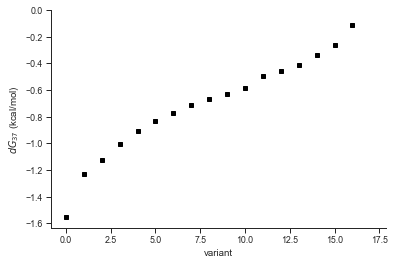

In [519]:
GCconst_df = df.query('GC == 50 & bottomScaffold == "GATCGATC" & dG_37_se < 0.08').sort_values('dG_37').iloc[np.arange(0, 450, 25), :]
plt.plot(GCconst_df.dG_37.values, 'ks')
plt.xlabel('variant')
plt.ylabel('$dG_{37}$ (kcal/mol)')
plt.ylim(top=0)
sns.despine()

## Export stuffs

In [537]:
pd.concat([tetraloop_explain_df, triloop_explain_df, loop_out_df.RefSeq, loop_center_df.RefSeq, GCconst_df.RefSeq],
          axis=0).to_csv('./data/uv_melt/design/loops_80_idt.csv')

In [536]:
pd.concat([loop_out_df.RefSeq, loop_center_df.RefSeq, GCconst_df.RefSeq],
          axis=0).to_csv('./data/uv_melt/design/loops_50_idt.csv')

In [555]:
pd.concat(
    [pd.read_csv('./data/uv_melt/design/MM_27_IDT.csv', index_col=0).RefSeq,
     pd.read_csv('./data/uv_melt/design/duplex_mm_bg_14_rc_idt.csv', index_col=0).rc,
     pd.read_csv('./data/uv_melt/design/loops_50_idt.csv', index_col=0).RefSeq],
    axis=0
).drop_duplicates().to_csv('./data/uv_melt/design/230112_idt.csv')

assert not pd.read_csv('./data/uv_melt/design/230112_idt.csv').iloc[:,0].apply(lambda x: x in measured).any()

## Make ECLComplexes airtable

In [617]:
oligo_df = pd.read_csv('./data/uv_melt/ECLOligos-Grid view.csv')
oligo_df = oligo_df['Name']
duplex_oligo = pd.DataFrame(oligo_df.apply(lambda x: x if ('5p' in x or '3p' in x) else np.nan).dropna())

def find_partner(s):
    if '5p' in s:
        return s.replace('_5p', '_3p')
    elif '_3p_rc' in s:
        return s.replace('_3p_rc', '_3p')
    else:
        return np.nan
    
    
duplex_oligo['partner'] = duplex_oligo['Name'].apply(find_partner)

duplex_oligo['SEQID'] = duplex_oligo['Name'].apply(lambda x: x.replace('_5p', '').replace('_3p_rc', '_ref'))

duplex_oligo = duplex_oligo.dropna().set_index('SEQID')
duplex_oligo.columns = ['StrandA', 'StrandB']

duplex_oligo.to_csv('./data/uv_melt/design/ECLduplexes.csv')

In [624]:
oligo_df = pd.read_csv('./data/uv_melt/ECLOligos-Grid view.csv')
# oligo_df = oligo_df['Name']
hairpin_oligo = oligo_df['Name'].apply(lambda x: x if not ('5p' in x or '3p' in x) else np.nan).dropna()

In [629]:
oligo_df.set_index('Name').loc[hairpin_oligo].to_csv('./data/uv_melt/design/ECLHairpins.csv')

## Design a hairpin test set too!

I forgot this part on 01/12 and placed the IDT order, but remembered on 01/13/2023.

1. Generate a bunch of random hairpins
2. Filter out those already in the array dataset
3. Filter out those that fold into alternative structures
4. Filter out those too stable or unstable (GC%)

In [630]:
import scripts.make_lib3 as design

In [741]:
def generate_random_hairpins(stack_length=6, loop_length=4, n_seq=1):
    """
    Returns:
        refseqs - (n_seq,) List[str]
        target_struct - str
    """
    bases = ['A', 'T', 'C', 'G']
    WC_pairs = ['AT', 'TA', 'CG', 'GC']
    
    stacks = np.random.choice(WC_pairs, (n_seq, stack_length))
    loop = np.random.choice(bases, (n_seq, loop_length))
    loops = [''.join(x) for x in loop]
    seqs = design.add_scaffold_2_stacks(stacks, scaffold='')
    refseqs = design.add_loops_2_seqs(loops, seqs)
    target_struct = '('*stack_length + '.'*loop_length + ')'*stack_length
    
    return refseqs, target_struct

def filter_hairpins(hp_df, arr, return_all_columns=False,
                    criteria=None):
    def has_runs(x):
        found = False
        forbid_list = ['AAAA', 'TTTT', 'CCCC', 'GGGG']
        for forbid_str in forbid_list:
            if forbid_str in x:
                found = True
                break
        return found
    
    if criteria is None:
        criteria = 'GC > 20 & GC < 80 &\
            dG_37 > -6 & dG_37 < 1 & \
            (~ measured) & \
            same_mfe_struct & (~ has_runs)'
    hp_df['GC'] = hp_df.RefSeq.apply(util.get_GC_content)
    hp_df['measured'] = hp_df.RefSeq.apply(lambda x: x in arr.RefSeq.values)
    hp_df['same_mfe_struct'] = hp_df.RefSeq.apply(lambda x: util.get_mfe_struct(x, celsius=5, sodium=.081) == target_struct)
    T = 37
    hp_df['dG_%d' % T] = hp_df.RefSeq.apply(lambda x: util.get_seq_ensemble_dG(x, T, sodium=0.081))
    hp_df['has_runs'] = hp_df.RefSeq.apply(has_runs)
    hp_df = hp_df.query(criteria)
    
    print('Designed %d hairpins' % (hp_df.shape[0]))
    
    if return_all_columns:
        return hp_df
    else:
        return hp_df[['RefSeq', 'TargetStruct']]

In [754]:
def design_hairpins(arr, stack_length=6, loop_length=4, n_seq=100, **kwargs):
    refseqs, target_strct = generate_random_hairpins(stack_length=stack_length, loop_length=loop_length, n_seq=n_seq)
    hp_df = pd.DataFrame(dict(RefSeq=refseqs, TargetStruct=target_struct))
    hp_df = filter_hairpins(hp_df, arr, **kwargs)
    return hp_df

In [744]:
n = 16
stem_loop_len_list = [(5,4), (6,4), (7,4), (5,3), (6,3), (7,3)]
hp_df_list = []
for stem_len, loop_len in stem_loop_len_list:
    hp_df = design_hairpins(arr, stem_len, loop_len, 50).iloc[:n, :]
    hp_df_list.append(hp_df)

Designed 0 hairpins
Designed 29 hairpins
Designed 0 hairpins
Designed 0 hairpins
Designed 0 hairpins
Designed 0 hairpins


In [761]:
hp_df = design_hairpins(arr, 6, 3, 200)

Designed 0 hairpins


In [760]:
criteria =  'GC > 20 & GC < 80 &\
            (~ measured)'
hp_df = design_hairpins(arr, 7, 4, 200, criteria=criteria)

Designed 192 hairpins


The problem here is, apart from the stem length 6 loop length 4 combination, the rest of the lengthes all get filtered out, mostly because the mfe structure do not match. For now I will only order the (6, 4) combination.

In [772]:
np.random.seed(48)
hp_df = design_hairpins(arr, 6, 4, 100).iloc[:48, :]

hp_df.index = ['HP%03d' % (i+1) for i in range(48)]

hp_df.to_csv('./data/uv_melt/design/test_hairpin_6_4.csv')

Designed 49 hairpins


In [774]:
hp_df.RefSeq.to_csv('./data/uv_melt/design/test_hairpin_6_4_idt.csv', header=None)